# Process
I first tried out training DDPM, after 1-2 days realized it would be harder to debug&train than something like a VAE / GAN so I started off with a VAE

Experimented with it for a while, and, as expected, got blurry and very average results at the end

In [8]:
%load_ext autoreload
%autoreload 2

import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.v2 import Compose, Normalize, Lambda, Resize, \
    RandomHorizontalFlip, RandomRotation, RandomResizedCrop, ColorJitter, RandomGrayscale
from tqdm.auto import tqdm

device = 'cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from data import CatDataset
from diffusion import Diffusion, get_named_beta_schedule
from trainer import Trainer
from models.unet import UNet

In [34]:
ds = CatDataset(
    'data/cats_256_aligned',
    transform = Compose([
        Lambda(lambda x: x.float()),
        Resize(64),
        Normalize((127.5,) * 3, (127.5,) * 3),
    ]),
    augmentation = Compose([
        Normalize((-1,) * 3, (2,) * 3),
        ColorJitter(0.2, 0.2, 0.2, 0.2),
        RandomGrayscale(p=0.05),
        RandomHorizontalFlip(),
        RandomRotation(30),
        RandomResizedCrop(64, scale=(0.6, 1.0)),
        Normalize((0.5,) * 3, (0.5,) * 3),
    ])
)

sample.shape torch.Size([3, 64, 64])
sample.min() tensor(-0.9941)
sample.max() tensor(1.)


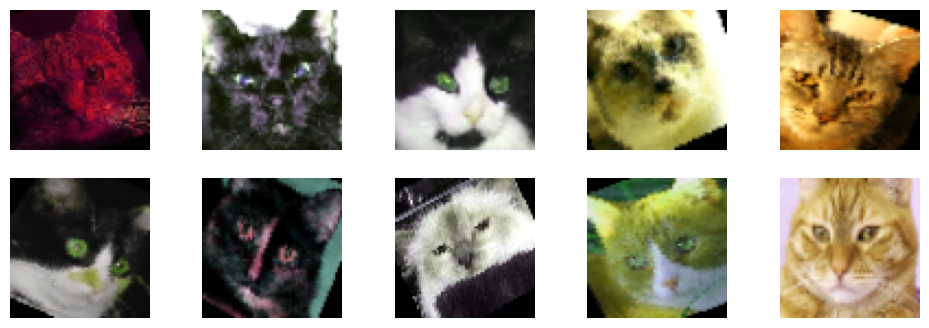

In [35]:
# Inspect dataset
indices = np.random.choice(len(ds), 10, replace=False)
fig, axes = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in zip(indices, axes.flatten()):
    ax.imshow(ds.augmentation(ds[i]).permute(1, 2, 0).numpy() * 0.5 + 0.5)
    ax.axis('off')

sample = ds[0]
print("sample.shape", sample.shape)
print("sample.min()", sample.min())
print("sample.max()", sample.max())


In [36]:
from models.vae import Encoder, Decoder, VAE

In [41]:
model = VAE(
    in_channels=3,
    base_channels=16,
    in_resolution=64,
    num_levels=5,
    latent_dim=512, 
    num_blocks_per_level=1,
    dropout=0.0
).cuda()


In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("encoder parameters", count_parameters(model.decoder))
print("decoder parameters", count_parameters(model.encoder))

encoder parameters 8570051
decoder parameters 11978464


In [8]:
trainer = Trainer(
    model,
    ds.train_loader(batch_size=256),
    ds.val_loader(batch_size=64),
    lr=1e-3,
    weight_decay=1e-4,
    num_epochs=100000,
    log_every=1,
    save_every=100,
    device='cuda',
    checkpoint_file='checkpoints/checkpoint_64_256_aug.pt'
)

In [9]:
trainer.run_loop(True)

 84%|████████▍ | 53/63 [00:45<00:08,  1.17it/s]


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [3]:
res = model.decoder(torch.randn(1, 64).cuda())
plt.imshow(res[0].permute(1, 2, 0).detach().cpu().numpy() * 0.5 + 0.5)

NameError: name 'model' is not defined

# Debug

In [13]:
from metrics import compute_metrics

In [16]:
compute_metrics(ds.test_loader(batch_size=64), model, fid_num_samples=1000)

  0%|          | 0/16 [00:00<?, ?it/s]/media/xallt/HardDrive/.virtualenv/catgen/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 75%|███████▌  | 12/16 [00:01<00:00,  6.19it/s]


KeyboardInterrupt: 

In [15]:
image = ds[0].cuda()
with torch.no_grad():
    image_enc = model.encoder(image.unsqueeze(0))[0]
    image_rec = model.decoder(image_enc)

/media/xallt/HardDrive/.virtualenv/catgen/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


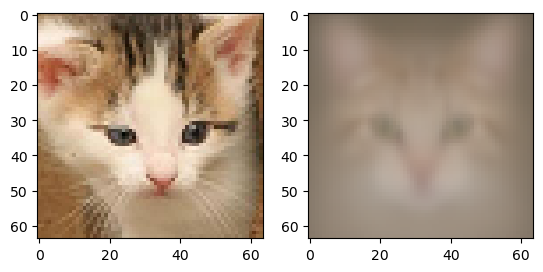

In [16]:
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
plt.subplot(1, 2, 2)
plt.imshow(image_rec[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)